In [1]:
import math 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3 * x**2 - 4 * x + 5

In [3]:
f(3.0)

20.0

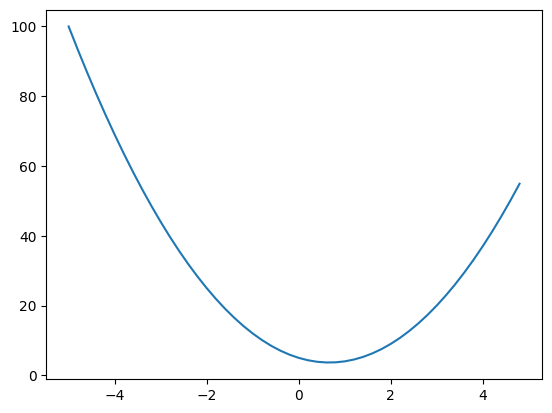

In [4]:
xs = np.arange(-5, 5, 0.2)
ys = f(xs)
plt.plot(xs, ys)

In [5]:
h = 0.01
x = 2 / 3
(f(x + h) - f(x)) / h

0.02999999999997449

In [6]:
a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c
b += h
d2 = a * b + c

print("d1", d1)
print("d2", d2)
print("slope", (d2 - d1) / h)

d1 4.0
d2 4.02
slope 1.9999999999999574


In [48]:
class Value:
    def __init__(self, data, _children=(), _op="", label="") -> None:
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self) -> str:
        return f"Value(data={self.data})"

    def __add__(self, other):
        # add constant
        other = other if isinstance(other, Value) else Value(other)

        out = Value(self.data + other.data, (self, other), "+")

        def _backward():
            # out with respect to self & other
            self.grad += out.grad
            other.grad += out.grad

        out._backward = _backward
        return out

    def __mul__(self, other):
        # add constant
        other = other if isinstance(other, Value) else Value(other)

        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
            # out with respect to self & other
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self * other
        # if we uses 'constant * Value', python will check Value to see if swap * can be applied

    def __truediv__(self, other):
        return self * other**-1

    def __pow__(self, other):
        assert isinstance(
            other, (int, float)
        ), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f"**{other}")

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad

        # !self._backward = _backward
        out._backward = _backward
        return out

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def exp(self):
        # ! out = Value(math.exp(x), (self,), "exp") 你看看这是人吗
        out = Value(math.exp(self.data), (self,), 'exp')
        def _backward():
            self.grad += out.data * out.grad

        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self,), "tanh")

        def _backward():
            # out with respect to self & other
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward

        return out
    def __radd__(self, other):
        return self + other
    
    def backward(self):
        self.grad = 1.0

        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        for node in reversed(topo):
            node._backward()

In [8]:
from graphviz import Digraph


def trace(root):
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
        for child in v._prev:
            edges.add((child, v))
            build(child)

    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"})  # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(
            name=uid,
            label="{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad),
            shape="record",
        )
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

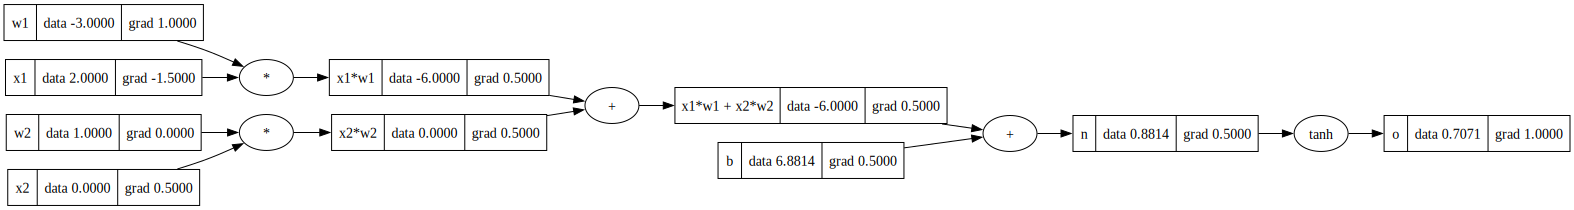

In [35]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh();o.label='o'
draw_dot(o)
o.backward()
draw_dot(o)

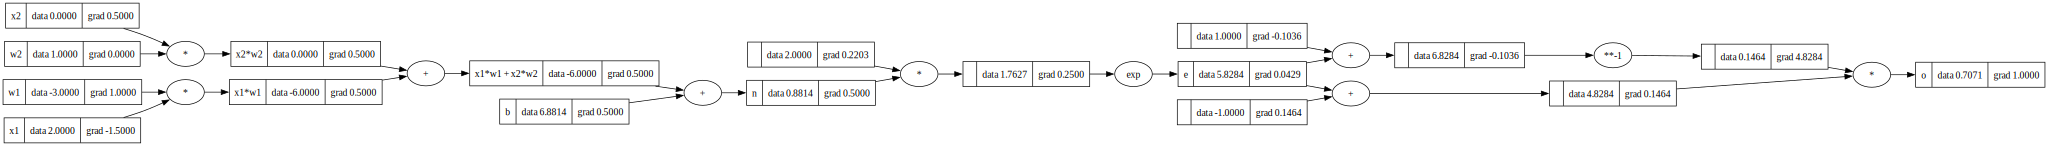

In [36]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
e = (2*n).exp();e.label='e'
o = (e-1) / (e+1);o.label='o'
o.backward()
draw_dot(o)

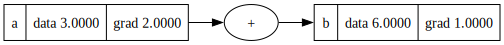

In [11]:
# solving the bug
# we use a variable more than once, so we can't just set the grad with '=', and uses '+=' instead
a = Value(3.0, label='a')
b = a + a;b.label='b'
b.backward()
draw_dot(b)

In [38]:
import torch

x1 = torch.Tensor([2.0]).double();  x1.requires_grad=True
x2 = torch.Tensor([0.]).double(); x2.requires_grad=True
w1 = torch.Tensor([-3.]).double();w1.requires_grad=True
w2 = torch.Tensor([1.]).double();w2.requires_grad=True
b = torch.Tensor([6.8813735870195432,]).double();b.requires_grad=True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()
print('x2', x2.grad.item())
o.data, o.data.item()

0.7071066904050358
x2 0.5000001283844369


(tensor([0.7071], dtype=torch.float64), 0.7071066904050358)

In [52]:
import random
from re import I


class Neuron:
    def __init__(self, nin) -> None:
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout) -> None:
        self.neurons = [Neuron(nin) for _ in range(nout)]


    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self,):
        params = []
        for neuron in self.neurons:
            ps = neuron.parameters()
            params.extend(ps)
        return params

class MLP:
    def __init__(self, nin, nouts: list) -> None:
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.7942168437550748)

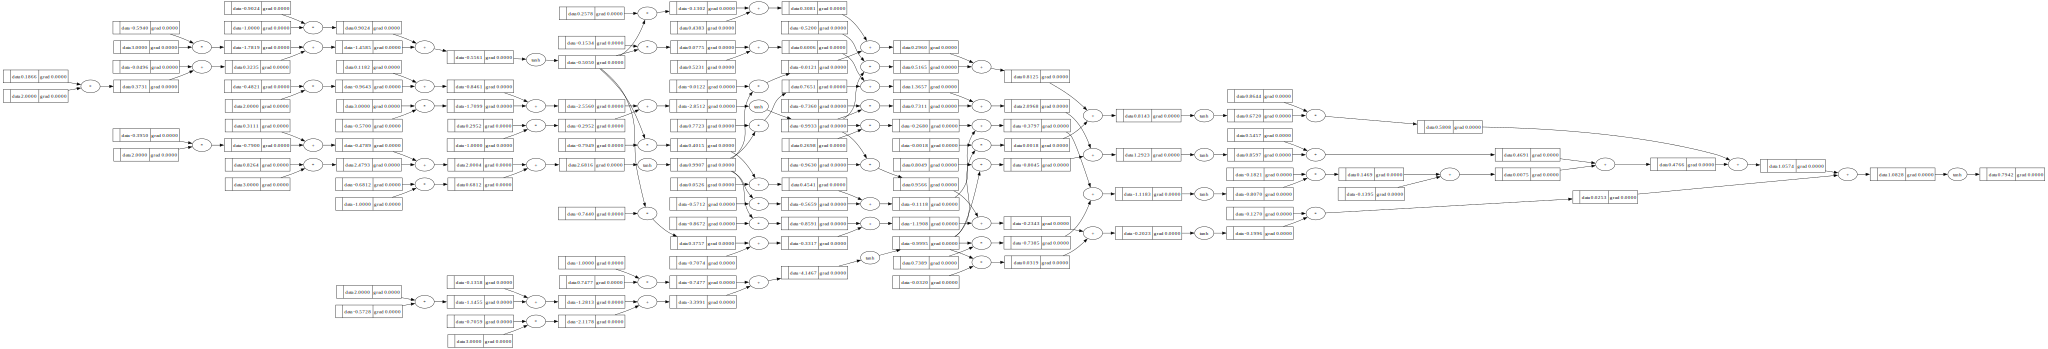

In [53]:
draw_dot(n(x))

In [54]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [55]:
for k in range(20):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad
  
  print(k, loss.data)
  

0 3.887860629232175
1 1.426088029888975
2 0.3283184899193125
3 0.05618490691323136
4 0.04558808219666432
5 0.038258646695472256
6 0.032897636798310495
7 0.028812672698011788
8 0.025600937917557874
9 0.023012320472521615
10 0.02088345449302606
11 0.019103202582293297
12 0.017593385001795855
13 0.016297441991369326
14 0.015173466999511652
15 0.014189765641042419
16 0.013321934236214649
17 0.012550884841022632
18 0.011861477847976445
19 0.011241555054072457


In [56]:
n.parameters()

[Value(data=0.04440827891010124),
 Value(data=-0.31964960229673334),
 Value(data=-1.0752832162307964),
 Value(data=-0.08316228633375491),
 Value(data=-0.5104421706184485),
 Value(data=0.634665766113002),
 Value(data=-0.9597677525465169),
 Value(data=0.08917566020626158),
 Value(data=-0.13933529160731684),
 Value(data=-0.5208866909467486),
 Value(data=0.5634403115228721),
 Value(data=0.36348530701781573),
 Value(data=-0.6971579133933264),
 Value(data=-0.7305804568111471),
 Value(data=0.6690967760613348),
 Value(data=-0.2252690385568312),
 Value(data=-0.8325262292284608),
 Value(data=-0.652223371913184),
 Value(data=0.2792075951859609),
 Value(data=0.6856424784096985),
 Value(data=0.16404262096256284),
 Value(data=-0.0712420984169957),
 Value(data=0.9868625924571536),
 Value(data=-0.7653467252128915),
 Value(data=0.8335120361940493),
 Value(data=0.3721924036702012),
 Value(data=0.39714031501048924),
 Value(data=0.29863914127089675),
 Value(data=-0.6173954583459916),
 Value(data=0.0202380

In [ ]:
ypred